In [2]:
import pandas as pd

df = pd.read_csv('/content/bank_data_train.csv')

In [3]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2cbb03223d030137889e827d7fd1028ce824bb6697f311383b289d839f37ec00
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, ADASYN
import shap
from lime.lime_tabular import LimeTabularExplainer

In [5]:
df.head()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,...,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
1,146842,0,0.041033,NaN,NaN,NaN,NaN,0.0,0.166667,0.186107,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,146843,0,0.006915,0.0,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
3,146844,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
4,146845,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [6]:
zero_cols = []
for col in df.columns:
    if df[col].dtype != 'object':
        if df[col].max() == 0 and df[col].min() == 0:
            zero_cols.append(col)
df.drop(zero_cols, axis=1, inplace=True)

In [7]:

df.drop('CLNT_JOB_POSITION', axis=1, inplace=True)

In [8]:
threshold = 0.8
data_cleaned = df.loc[:, df.isnull().mean() < threshold]

In [9]:
data_cleaned = data_cleaned.dropna(subset=['TARGET'])

In [10]:
X = data_cleaned.drop(columns=['TARGET', 'ID'])
y = data_cleaned['TARGET']

In [11]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [12]:

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [15]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [16]:
y_pred_rf = rf.predict(X_test)

In [17]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2660
         1.0       0.27      0.20      0.23       238

    accuracy                           0.89      2898
   macro avg       0.60      0.58      0.59      2898
weighted avg       0.88      0.89      0.88      2898

Random Forest Confusion Matrix:
[[2529  131]
 [ 190   48]]


In [18]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

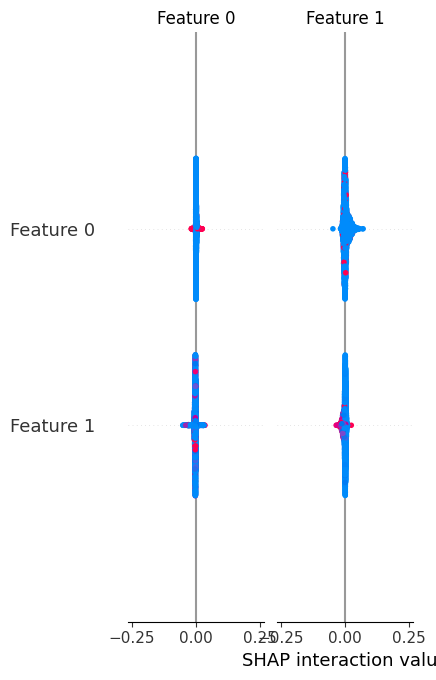

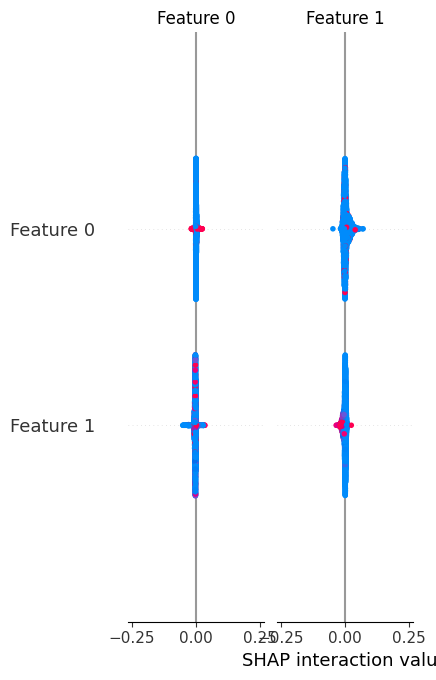

In [19]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

In [20]:
svm = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, tol=0.001, cache_size=500, max_iter=1000, random_state=42, class_weight='balanced')
svm.fit(X_train, y_train)

SVC(cache_size=500, class_weight='balanced', max_iter=1000, probability=True,
    random_state=42)

In [21]:
y_pred_svm = svm.predict(X_test)

In [22]:
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      2660
         1.0       0.07      0.26      0.12       238

    accuracy                           0.67      2898
   macro avg       0.49      0.48      0.46      2898
weighted avg       0.85      0.67      0.74      2898

SVM Confusion Matrix:
[[1886  774]
 [ 176   62]]
